# Seminar 11: Deep Learning
At the seminar on PyTorch we trained an MLP for classification of MINIST digits.

![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar12/img/pic1.png)

```python
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)
```

This simple neural network architecture worked pretty well on MNIST.
At this seminar, we will try solving the same problem of 10-class classification of small pictures for another dataset --- CIFAR-10.
![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar13/img/cifar.png)

In contrast to MNIST, this dataset won't be that easy to classify for our MLP, so we will need to use some deep learning trickery to make it better.

In [ ]:
if 'google.colab' in str(get_ipython()):
    import ssl
    import sys

    !wget https://raw.githubusercontent.com/adasegroup/ML2023_seminars/master/seminar11/utils.py -P local_modules -nc
    sys.path.append('local_modules')

    ssl._create_default_https_context = ssl._create_unverified_context

--2023-05-06 14:28:00--  https://raw.githubusercontent.com/adasegroup/ML2023_seminars/master/seminar11/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2432 (2.4K) [text/plain]
Saving to: ‘local_modules/utils.py’

utils.py            100%[===================>]   2.38K  --.-KB/s    in 0s      

2023-05-06 14:28:00 (35.6 MB/s) - ‘local_modules/utils.py’ saved [2432/2432]



In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import trange

import utils as seminar_utils

## 1. Intro
Let's recall that training a neural network is mainly based on four elements:
* what we train on, i.e the data,
* what we train, i.e the architecture of the neural network,
* how we measure the training performance, i.e the loss function,
* and how we update the weights of the neural network, i.e the optimizer.

If your network performs bad, these are the four things that you want to change.
Today we will be looking only at three of them, and we will keep the loss function the same.

We will use [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), as in the seminar on PyTorch.
```python
loss_function = torch.nn.CrossEntropyLoss()
```

### The data: PyTorch Dataset and DataLoader
For working with data, PyTorch provides convenient functionality concentrated around classes [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) and [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.DataLoader).
It also has a library called [torchvision](https://pytorch.org/vision/stable/index.html) with predefined classes for popular computer vision datasets.

For example, we can use [torchvision.datasets.MNIST](https://pytorch.org/vision/stable/datasets.html#mnist)
or [torchvision.datasets.CIFAR10](https://pytorch.org/vision/stable/datasets.html#cifar):
we specify the directory in which the dataset will be located, indicate that we want to download it, and that we want to select the training subset.

In [ ]:
mnist_train = torchvision.datasets.MNIST('./mnist', download=True, train=True)
cifar_train = torchvision.datasets.CIFAR10('./cifar', download=True, train=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 92668474.86it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95759441.76it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26596615.75it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11752331.13it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 79922074.18it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


Then we can, basically, use these instances as lists of pairs input-target.

In [ ]:
print(len(mnist_train))
input_image, target_class = mnist_train[0]
print(target_class)
input_image

60000
5


50000
6


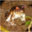

In [ ]:
print(len(cifar_train))
input_image, target_class = cifar_train[0]
print(target_class)
input_image

To convert input images from `PIL.Image` to` torch.Tensor`, we can use the `transform` parameter.

In [ ]:
mnist_train = torchvision.datasets.MNIST('./mnist', train=True, transform=torchvision.transforms.ToTensor())
input_tensor, target_class = mnist_train[0]
print(input_tensor)
input_tensor.shape

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

torch.Size([1, 28, 28])

In the seminar on PyTorch we saw that PyTorch Modules can process batches of input indepdendently and in parallel.
To combine the samples into batches, we can use [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.DataLoader).

We initialize it with the dataset, set the batch size,
and also can set the number of parallel processes that will be loading and processing the data with `num_workers`,
and can specify that we want to randomly shuffle the data.

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, num_workers=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Then we can iterate over the batches in the loader.

In [ ]:
for batch_i, (input_tensor, target_class) in enumerate(train_loader):
    print(batch_i)
    print(input_tensor.shape, target_class.shape)
    print(target_class[:5])
    break

0
torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([6, 5, 6, 9, 2])


### The architechture: PyTorch Module
We will start with the same architecture that we had at the seminar on PyTorch:
```python
torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)
```

This architecture expects the input of shape `[**, input_size]`,
where `**` are batch dimensions and `input_size` is an integer,
so we need to reshape each input image of shape `[channels_n, height, width]` into a 1D array with `channels_n * height * width` elements.

For incapsulation of things like this reshape, PyTorch has a base class [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module).

So, let's make a class `MLP` which inherits from `torch.nn.Module`.
We pass to the constructor the size of the input image from which we calculate the `input_size` of the first linear block and we store the sequence of all blocks in the `mlp` attribute.
When we call `model(input)`, the method `forward` is used internally, so we reshape the input in this method.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_image_size, hidden_dim_size, number_of_classes):
        r"""
        Parameters
        ----------
        input_image_size : iterable of int
            (channels_n, height, width)
        hidden_dim_size : int
        number_of_classes : int
        """
        super().__init__()

        input_size = input_image_size[0] * input_image_size[1] * input_image_size[2]
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_dim_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim_size, number_of_classes)
        )

    def forward(self, x):
        r"""
        Parameters
        ----------
        x : torch.Tensor
            of shape [batch_size, channels_n, height, width]

        Returns
        -------
        y : torch.Tensor
            of shape [batch_size, classes_n]
        """
        batch_size = len(x)
        x = x.reshape(batch_size, -1)  # b, c * h * w
        return self.mlp(x)

In [ ]:
inputs, targets = next(iter(train_loader))
inputs.shape

torch.Size([64, 1, 28, 28])

In [ ]:
model = MLP(input_image_size=[1, 28, 28], hidden_dim_size=80, number_of_classes=10)
nn_outputs = model(inputs)
nn_outputs.shape

torch.Size([64, 10])

### The optimizer
We will start with Gradient Descent with momentum as our baseline.
```python
torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
```
We can access the parameters of the model with `model.parameters()`, as before:
it will collect the parameters from all attributes of the model that are also `torch.nn.Module`.

#### Gradient Descent vs Stochastic Gradient Descent vs Mini-Batch Gradient Descent
At the seminar on PyTorch, we calculated the outputs of the neural network in parallel for the entire dataset, averaged the loss over the entire dataset and updated the network parameters w.r.t this average.
This variant of Gradient Descent is called just Gradient Descent or Batch Gradient Descent.
```python
# all_inputs.shape == [dataset_size, input_size]
output = model(all_inputs)
loss = loss_f(output, all_targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

Real-world datasets are rather large, so parallel computation on the whole dataset is inefficient in memory.
Therefore, there is another well-established variant called Stochastic Gradient Descent.
In this variant, we select samples in random order one at a time, calculate the model output and the loss w.r.t only this single sample and update the weights
```python
for input, target in data:
    # input.shape == [1, input_size]
    output = model(input)
    loss = loss_f(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

Doing calculations in parallel for multiple samples is usually more efficient in time than in cycle for a single sample.
So in practice, a combination of these two variants, called Mini-Batch Gradient Descent, is used.
Here, we take the samples not one at a time but in batches of several samples
```python
for input_batch, target_batch in data:
    # input_batch.shape == [batch_size, input_size];  1 < batch_size < dataset_size
    output = model(input_batch)
    loss = loss_f(output, target_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```
The optimal batch size is chosen experimentally; good values for today's seminar are in range 64-512.

### Training procedure

In [ ]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=1):
    # send the model to that device
    model = model.to(device)
    # initialize some visualization code that you don't need to care about
    monitor = seminar_utils.Monitor()

    # one full cycle on train data is called epoch
    for epoch in trange(epochs_n):
        # switch the model to the train mode
        # later on we will have some modules that function differently in train and test mode
        model.train()
        for model_input, target in train_loader:
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # do some visualization
            monitor.add_loss_value(loss.item())

        # evaluate the model
        # switch the model to the test mode
        model.eval()
        train_accuracy = seminar_utils.get_accuracy(model, train_loader, device)
        val_accuracy   = seminar_utils.get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)

        if epoch % plot_each == 0:
            monitor.show()

Now, let's put everything together and try to train an `MLP` classifier first on MNIST then on CIFAR-10.

#### MNIST

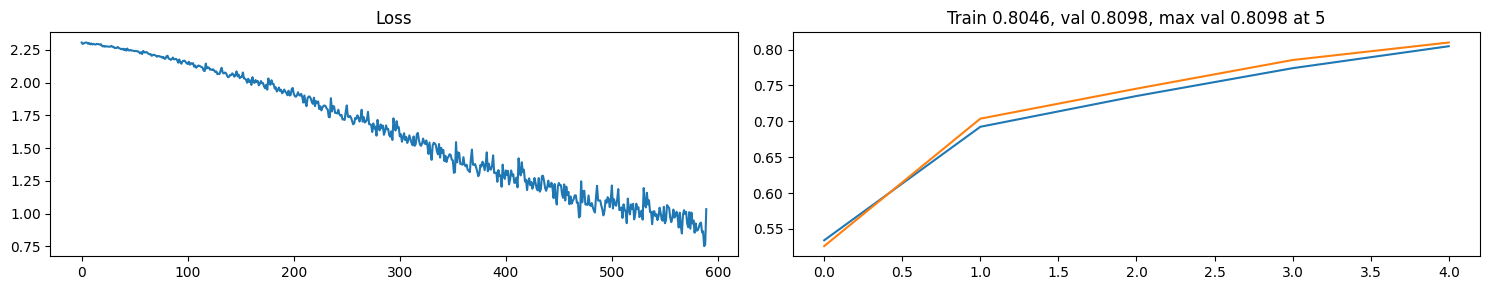

100%|██████████| 5/5 [01:42<00:00, 20.53s/it]


In [ ]:
seminar_utils.set_random_seeds(device=device)

mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True,
                                         transform=torchvision.transforms.ToTensor())
mnist_val = torchvision.datasets.MNIST('./mnist', train=False, download=True,
                                       transform=torchvision.transforms.ToTensor())
batch_size = 512
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=4)

model = MLP([1, 28, 28], 100, 10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=5)

#### CIFAR

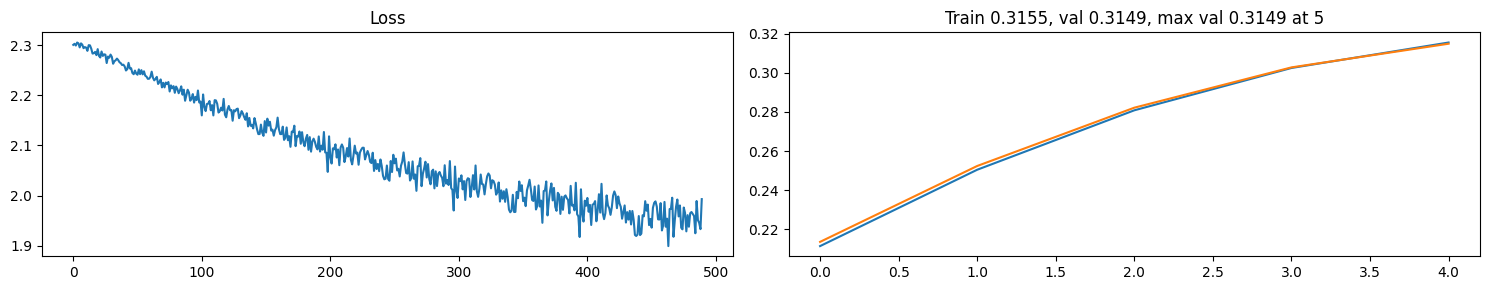

100%|██████████| 5/5 [01:44<00:00, 20.98s/it]


In [ ]:
seminar_utils.set_random_seeds(device=device)

cifar_train = torchvision.datasets.CIFAR10('./cifar', train=True, download=True,
                                           transform=torchvision.transforms.ToTensor())
cifar_val = torchvision.datasets.CIFAR10('./cifar', train=False, download=True,
                                         transform=torchvision.transforms.ToTensor())
batch_size = 512
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size, num_workers=4)

model = MLP([3, 32, 32], 100, 10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=5)

We see two things.
First, training neural networks on real datasets can take quite a lot of time, although in this example it is still very fast.
Second, while on MNIST our MLP achieves 90% accuracy in a minute of training and without overfitting,
on CIFAR the accuracy is significantly lower.

In this seminar we will try different deep learning techniques to get better performance at CIFAR classification.
We will look at these techniques on MNIST and then you will try them for CIFAR.

## 2. Develop on subset
Firstly, we will select small subsets from the whole training and validation datasets to be able to quickly try different things.

For this we will use [torch.utils.data.Subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset),
to which we pass the source dataset and a set of indices that select a subset.

In [ ]:
subset_size = 64
mnist_train_subset = torch.utils.data.Subset(mnist_train, torch.arange(subset_size))
mnist_val_subset = torch.utils.data.Subset(mnist_val, torch.arange(subset_size))

Let's check that our subsets are not too small and still represent the original datasets.

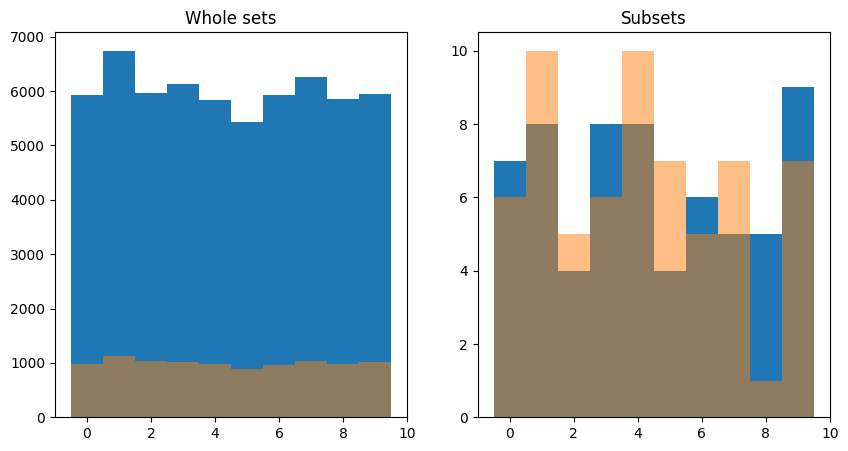

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Whole sets')
ax[0].hist([target for _, target in mnist_train], bins=10, range=(-.5, 9.5));
ax[0].hist([target for _, target in mnist_val], bins=10, range=(-.5, 9.5), alpha=.5);
ax[1].set_title('Subsets')
ax[1].hist([target for _, target in mnist_train_subset], bins=10, range=(-.5, 9.5));
ax[1].hist([target for _, target in mnist_val_subset], bins=10, range=(-.5, 9.5), alpha=.5);

These subsets are bad --- they have a distribution of samples different from the full datasets.
But they are not awful, let's keep them and see what we can achieve.

Let's see how the model performs on these subsets.

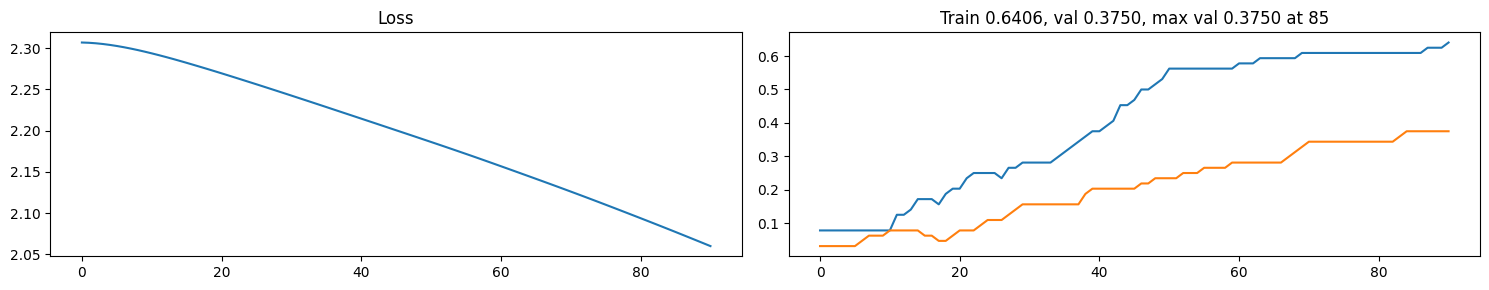

100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


In [ ]:
seminar_utils.set_random_seeds(device=device)

batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_train_subset, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(mnist_val_subset, batch_size=batch_size, num_workers=4)

model = MLP([1, 28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

First, based on the loss curve we see that the lerning rate is too small --- let's make it larger.

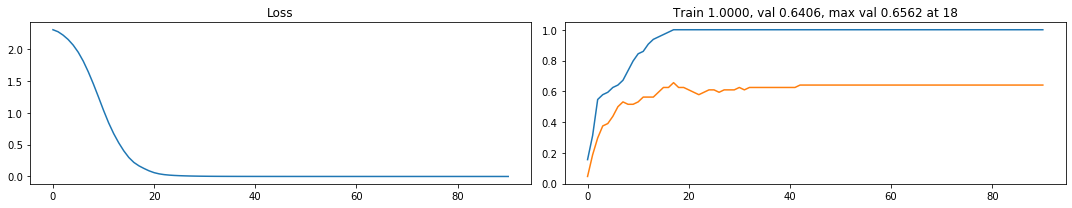

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


In [ ]:
seminar_utils.set_random_seeds(device=device)

model = MLP([1, 28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

Second, we see that the model achieves perfect accuracy on the training set and, as expected, stops learning.
However, the accuracy on the validation set is low.
This is called overfitting: the model is not general and performs poorly on the data different from that it was trained on.
Let's try data augmentation to beat that.

## 3. Augment your data
Let's take a look at threes in our training and validation data.

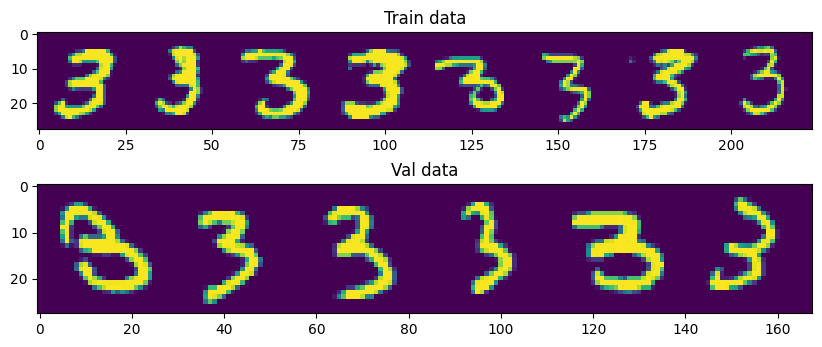

In [ ]:
f, ax = plt.subplots(2, figsize=(10, 4))
ax[0].set_title('Train data')
ax[1].set_title('Val data')
for x, y in train_loader:
    x = x[:, 0][y == 3]
    ax[0].imshow(np.hstack(x))
for x, y in val_loader:
    x = x[:, 0][y == 3]
    ax[1].imshow(np.hstack(x))

They are different, but not that different.
For example, the first three on the left from train and the second on the right from validation look pretty similar, as if one is a tilted version of the other.
So we can artificially expand the training data by randomly deforming the samples, e.g stretching, rotating them etc.
This is called data augmentation.

Let's try random rotations in the range of [-30, 30] degrees, random shears by [-30, 30] degrees, and random scaling by the factor 0.7 to 1.05 using the class [torchvision.transforms.RandomAffine](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomaffine#torchvision.transforms.RandomAffine).

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=30, shear=30, scale=(.7, 1.05)),
    torchvision.transforms.ToTensor()
])

mnist_train_augmented = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform=transform)

mnist_train_subset = torch.utils.data.Subset(mnist_train_augmented, torch.arange(64))
train_loader = torch.utils.data.DataLoader(mnist_train_subset, batch_size=64, num_workers=4)

Now we get infinite number of variations for each of our 64 train samples.

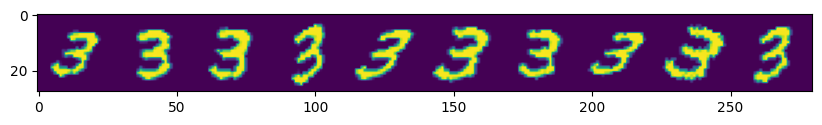

In [ ]:
augmentations = [mnist_train_subset[7][0][0] for i in range(10)]
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack(augmentations))

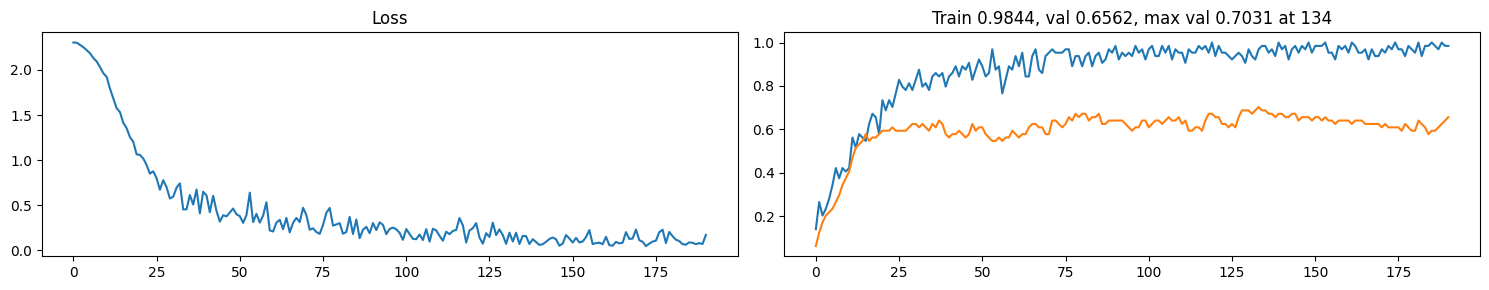

100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


In [ ]:
seminar_utils.set_random_seeds(device='cuda')

model = MLP([1, 28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=200, plot_each=10)

Now our model does not train that easily to the perfect train accuracy, but it still heavily overfits.
Let's try a different architecture.

## 4. Use CNNs
Overfitting, in its essence, occurs when the model has a lot of trained parameters and can, basically, memorize the correct answers for the training data instead of learning to solve the task in general.
But simply reducing the number of trained parameters will most likely make the network weaker and reduce its performance.
Instead of simply reducing the number of parameters, it is better to constrain the family of functions that the network can represent via choosing the proper architecture, taking into account the nature of the task.

For processing of visual information, like images that we are working with today,
Convolutional Neural Networks, or simply CNNs, are the de-facto standard.
They are built upon two types of blocks, or layers --- convolutional layers and pooling layers.

Convolutions in CNNs look for some patterns in the input image or feature map.
For example, if we want to find this zero in the image

In [ ]:
images_batch

NameError: ignored

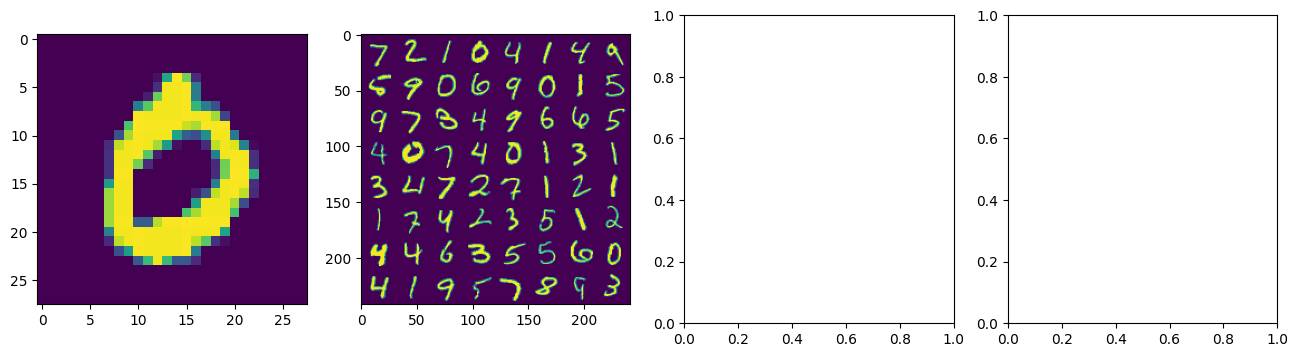

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

images_batch, _ = next(iter(val_loader))
images_grid = torchvision.utils.make_grid(images_batch, nrow=8)[:1]
ax[1].imshow(images_grid[0])

zero = mnist_val_subset[3][0]
ax[0].imshow(zero[0])

we can use a convolutionional layer [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) with this zero as the kernel.

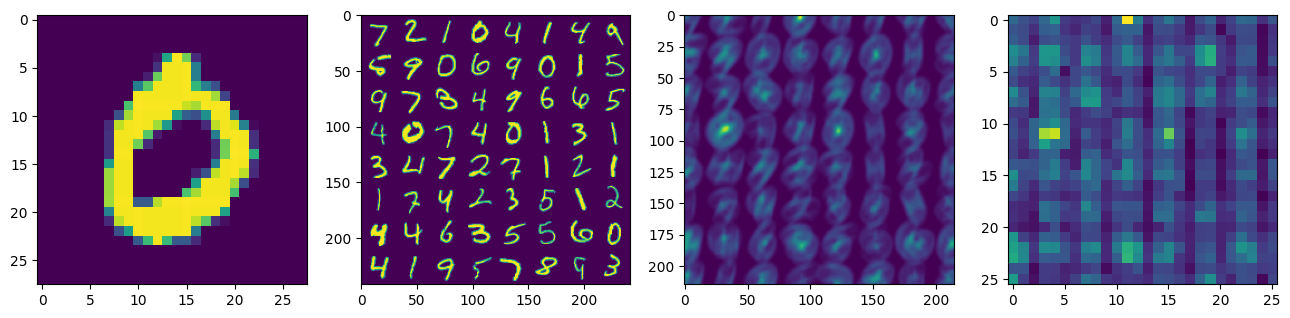

In [ ]:
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=28, bias=False)
conv.weight.data[:] = zero

conv_out = conv(images_grid[None])

ax[2].imshow(conv_out.data[0, 0])
fig

The convolution slides its kernel, this zero, over the image and outputs the correlation of its kernel with a part of the image.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

The second basic block of CNNs, pooling layers, simply reduce the dimensions of the output,
which lowers the number of computations in the following layers and forces learning more representative kernels.

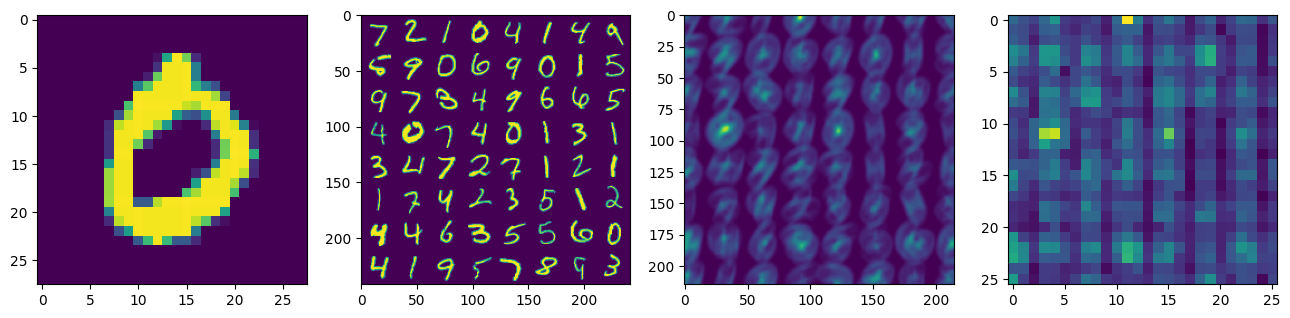

In [ ]:
pool = torch.nn.MaxPool2d(kernel_size=8)
pool_out = pool(conv_out)

ax[3].imshow(pool_out.data[0, 0])
fig

We will try a CNN similar in structure to [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).
It consists of two parts: a convolutional feature extractor and a fully-connected classifier.
![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar13/img/lenet.png)

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, input_image_size, number_of_classes):
        super().__init__()
        in_channels, height, width = input_image_size

        # convolutional feature extractor
        self.stage1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1),
            torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.stage2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # fully-connected classifier
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(16 * (height // 4) * (width // 4), 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, number_of_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.stage1(x)
        x = self.stage2(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        return x

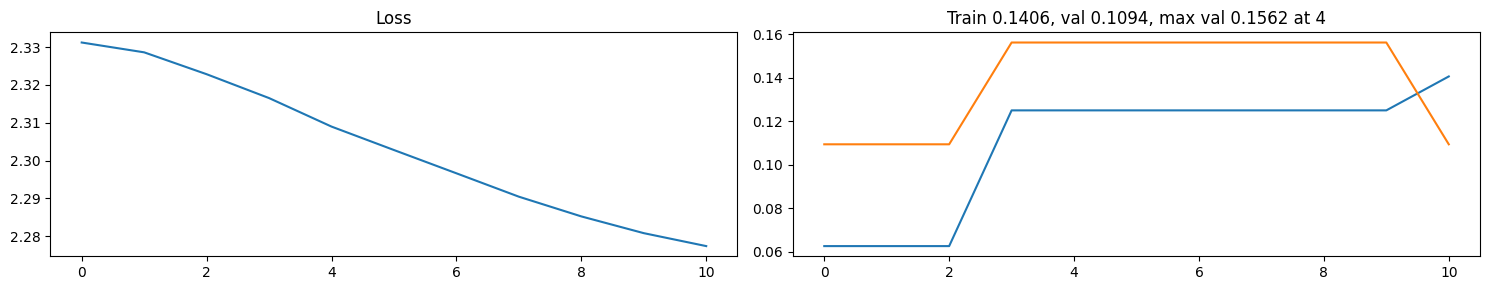

  6%|▌         | 11/200 [00:19<04:37,  1.47s/it]

In [ ]:
seminar_utils.set_random_seeds(device=device)

model = CNN([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=200, plot_each=10)

Now the training is unstable. Let's try Batch Normalization to counter this.

## 5. Use BatchNorm
Batch normalization, as the name implies, normalizes the input in the batch dimension.
It helps to reduce overfitting effects and stablizes training (see this [explanation by Ian Goodfellow](https://youtu.be/Xogn6veSyxA) on how Batch normalization helps training NNs).

Rougly speaking, we need to insert Batch Normalization layers between each pair of layers with trainable parameters.
In our case, this means that we add [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm2d#torch.nn.BatchNorm2d) after each convolutional layer and [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm1d#torch.nn.BatchNorm1d) after the first linear layer.

In [ ]:
class CNNBN(torch.nn.Module):
    def __init__(self, input_image_size, number_of_classes):
        super().__init__()
        in_channels, height, width = input_image_size

        self.stage1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(8),  ## <---
            torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.BatchNorm2d(8),  ## <---
        )
        self.stage2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),  ## <---
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.BatchNorm2d(16),  ## <---
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(16 * (height // 4) * (width // 4), 20),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(20),  ## <---
            torch.nn.Linear(20, number_of_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.stage1(x)
        x = self.stage2(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        return x

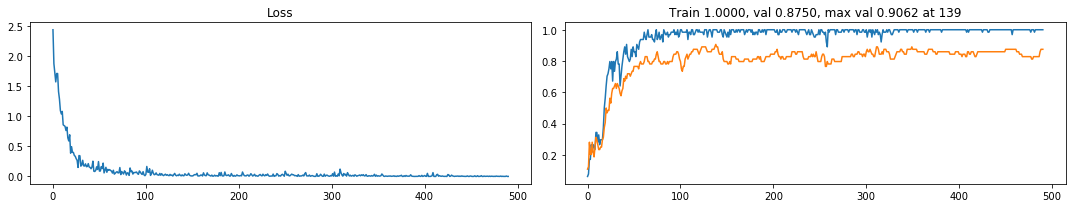

100%|██████████| 500/500 [02:03<00:00,  4.03it/s]


In [ ]:
seminar_utils.set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10)

We got a decent result taking into account that our training dataset consists of only 64 samples.
Let's see what else we can do.

We see that while the loss and train accuracy are relatively stable starting from 100-150 iterations, the validation accuracy jumps quite a lot.
This may be because of a too high learning rate.
If this is the case, we have, basically, two options to try to cope with this.

## 6. Schedule your LR
It would be ideal to make several epochs with a large learning rate to approximately reach the optimum quickly,
and only then continue with a small learning rate to get to the optimum more accurately.
PyTorch provides [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for this.

For example, we can use [torch.optim.lr_scheduler.MultiStepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiStepLR),
which decays the learning rate by a fixed factor `gamma` when the number of steps reaches certain `milestones`.

/home/ovoinov/.local/opt/miniconda3/envs/ml2021/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


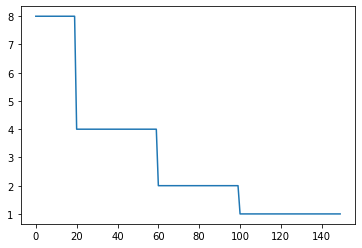

In [ ]:
model = CNNBN([1, 28, 28], 10)

optimizer = torch.optim.SGD(model.parameters(), lr=8)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(20, 60, 100), gamma=1/2)

lrs = []
for i in range(150):
    # do the training stuff
    # ...

    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(lrs)

We modify our training procedure to take scheduler as a parameter and do `scheduler.step()` at the end of each epoch.

In [ ]:
def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=1, scheduler=None):
    model = model.to(device)
    monitor = seminar_utils.Monitor()
    for epoch in trange(epochs_n):
        model.train()
        for model_input, target in train_loader:
            model_input = model_input.to(device)
            target = target.to(device)
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            monitor.add_loss_value(loss.item())

        model.eval()
        train_accuracy = seminar_utils.get_accuracy(model, train_loader, device)
        val_accuracy = seminar_utils.get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)

        if epoch % plot_each == 0:
            monitor.show()

        if scheduler is not None:  ## <---
            scheduler.step()       ## <---

Let's try training with learning rate 1e-1 for first 50 epochs,
and then decrease the learning rate by the factor of 2 once.

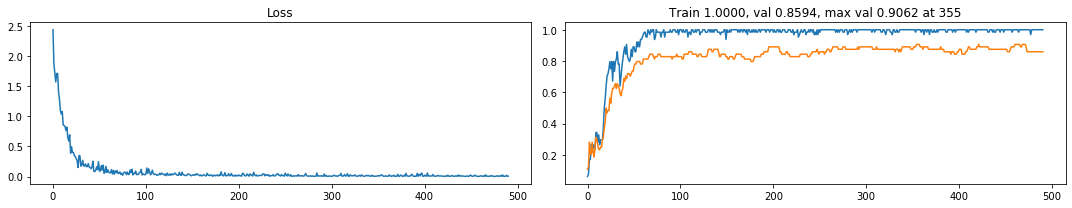

100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


In [ ]:
seminar_utils.set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(50, ), gamma=.5)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10, scheduler=scheduler)

LR scheduling made training a little bit more stable but did not improve the maximum validation accuracy.

## 7. Try a different optimizer

Another thing we could try is a different optimizer.
There is [a lot of them](https://ruder.io/optimizing-gradient-descent/), we will try [Adam](https://arxiv.org/pdf/1412.6980.pdf).
It adaptively scales the learning rate during the training for each individual parameter, and usually gives a decent performance with default parameters.

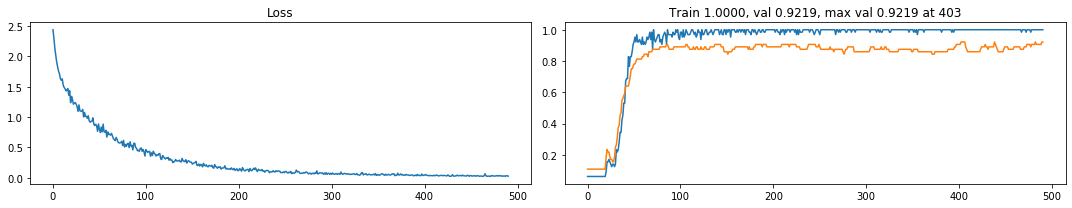

100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


In [ ]:
seminar_utils.set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10)

We get the same top performance as before.

Let's see how our best model performs on the whole validation dataset.

In [ ]:
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=4)
model.eval()
seminar_utils.get_accuracy(model, val_loader, device)

0.8678

Not bad, taking into account that we had only 64 training samples.

## 8. Recap on CIFAR
### Exercise
Now try all these techniques for CIFAR.
Your goal is to get the best performance on validation set (while using only the train data for training of course).
Don't forget to set random seeds `seminar_utils.set_random_seeds(device=device)` before each initialization of the model to get reproducible results.

Start on a subset and see how different techniques help.
What else you could do to further improve the performance:
* use standart ML techniques such as cross-validation, ensembling, etc --- surely will help, but don't use it here
* [`Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) the input --- may help, but may instead degrade the performance
* shuffle the training data using the `shuffle` parameter of `DataLoader`
* add $L_2$ regularization, aka weight decay, using the respective parameter of the optimizer or [`clamp`](https://pytorch.org/docs/stable/torch.html#torch.clamp) the weights directly --- unlikely will help since we already use BatchNorm (see e.g [this work](https://arxiv.org/abs/1706.05350))
* schedule learning rate more accurately --- most likely will help
* and, of course, STACK MORE LAYERS.